# Mapping longer-term changes in water extent with WOfS

* **Products used:** 
[wofs_ls_summary_annual](https://explorer.digitalearth.africa/products/wofs_ls),

## Background
The United Nations have prescribed 17 "Sustainable Development Goals" (SDGs). This notebook attempts to monitor SDG Indicator 6.6.1 - change in the extent of water-related ecosystems. Indicator 6.6.1 has 4 sub-indicators:
>    i. The spatial extent of water-related ecosystems <br>
>    ii. The quantity of water contained within these ecosystems <br>
>    iii. The quality of water within these ecosystems <br>
>    iv. The health or state of these ecosystems <br>

This notebook primarily focuses on the first sub-indicator - spatial extents.


## Description

The notebook demonstrates how to load, visualise, and analyse the [WOfS annual summary](https://docs.digitalearthafrica.org/en/latest/data_specs/Landsat_WOfS_specs.html) product to gather insights into the longer-term extent of water bodies. It provides a compliment to the [Water_extent_sentinel_2](Water_extent_sentinel_2.ipynb) notebook which focussing on more recent water extents at seasonal time intervals.


***

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

import datacube
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import geopandas as gpd
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
from IPython.display import Image
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.plotting import display_map, xr_animation
from deafrica_tools.dask import create_local_dask_cluster

/env/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:39473 Dashboard: /user/chad/proxy/8787/status,Cluster Workers: 1 Cores: 3 Memory: 28.14 GB


### Connect to the datacube

Activate the datacube database, which provides functionality for loading and displaying stored Earth observation data.

In [3]:
dc = datacube.Datacube(app='water_extent')

### Analysis parameters

The following cell sets the parameters, which define the area of interest and the length of time to conduct the analysis over.

The parameters are:

* `lat`: The central latitude to analyse (e.g. 10.338).
* `lon` : The central longitude to analyse (e.g. -1.055).
* `lat_buffer` : The number of degrees to load around the central latitude.
* `lon_buffer` : The number of degrees to load around the central longitude.
* `start_year` and `end_year`: The date range to analyse (e.g. `('1990', '2020')`.


**If running the notebook for the first time**, keep the default settings below.
This will demonstrate how the analysis works and provide meaningful results.
The example covers part of the Lake Sulunga. Tanzania. 


In [4]:
# Define the area of interest
lat = 0.6152 
lon =  36.0753

lat_buffer = 0.175
lon_buffer = 0.175

# Define the start year and end year
start_year = '1999'
end_year = '2021'

dask_chunks=dict(x=1000,y=1000)

# Combine central lat,lon with buffer to get area of interest
lat_range = (lat - lat_buffer, lat + lat_buffer)
lon_range = (lon - lon_buffer, lon + lon_buffer)

## View the area of Interest on an interactive map
The next cell will display the selected area on an interactive map.
The red border represents the area of interest of the study.
Zoom in and out to get a better understanding of the area of interest.
Clicking anywhere on the map will reveal the latitude and longitude coordinates of the clicked point.

In [5]:
display_map(lon_range, lat_range)

## Load WOfS annual summaries


In [6]:
#Create a query object
query = {
    'x': lon_range,
    'y': lat_range,
    'resolution': (-30, 30),
    'output_crs':'EPSG:6933',
    'time': (start_year, end_year),
    'dask_chunks':dask_chunks
}

#load wofs
ds = dc.load(product="wofs_ls_summary_annual",
             measurements=['frequency'],
             **query)

print(ds)

<xarray.Dataset>
Dimensions:      (time: 23, x: 1127, y: 1489)
Coordinates:
  * time         (time) datetime64[ns] 1999-07-02T11:59:59.999999 ... 2021-07...
  * y            (y) float64 1.008e+05 1.008e+05 ... 5.620e+04 5.618e+04
  * x            (x) float64 3.464e+06 3.464e+06 ... 3.498e+06 3.498e+06
    spatial_ref  int32 6933
Data variables:
    frequency    (time, y, x) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref


## Facet plot a subset of the annual WOfS summaries

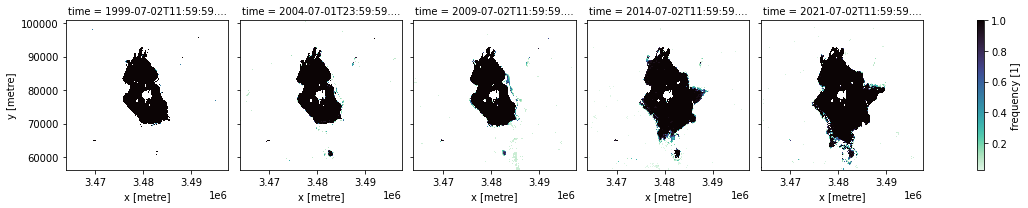

In [7]:
ds.where(ds.frequency>0).isel(time=[0,5,10,15,-1]).frequency.plot(col='time', col_wrap=5, cmap=sns.color_palette("mako_r", as_cmap=True));

## Animating time series
In the next cell, we plot the dataset we loaded above as an animation GIF, using the [`xr_animation`](../Frequently_used_code/Animated_timeseries.ipynb) function.
The `output_path` will be saved in the directory where the script is found and you can change the names to prevent files overwrite.

Exporting animation to annual_water_frequency.gif


  0%|          | 0/23 (0.0 seconds remaining at ? frames/s)

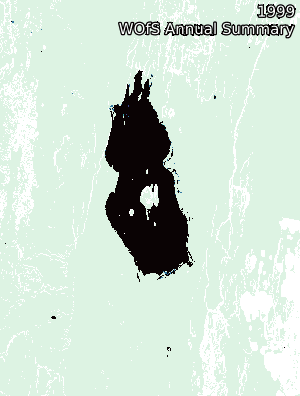

In [9]:
out_path = 'annual_water_frequency.gif'

xr_animation(ds=ds, 
             output_path=out_path,
             interval=400,
             bands=['frequency'], 
             show_text='WOfS Annual Summary', 
             show_date = '%Y',
             width_pixels=300,
             annotation_kwargs={'fontsize': 15},
             imshow_kwargs={'cmap': sns.color_palette("mako_r", as_cmap=True), 'vmin': 0.0, 'vmax': 1.0},
             colorbar_kwargs={'colors': 'black'},
             show_colorbar=False) 

# Plot animated gif
plt.close()
Image(filename=out_path)

## Calculate the annual area of water extent

The number of pixels can be used for the area of the waterbody if the pixel area is known. 
Run the following cell to generate the necessary constants for performing this conversion.

In [10]:
pixel_length = query["resolution"][1]  # in metres
m_per_km = 1000  # conversion from metres to kilometres
area_per_pixel = pixel_length**2 / m_per_km**2

### Threshold WOfS annual frequency to classify water/not-water

Calculates the area of pixels classified as water (if `ds.frequency` is > 0.20, then the pixel will be considered regular open water during the year)

In [11]:
water_threshold = 0.20

In [12]:
#threshold
water_extent = ds.frequency > water_threshold

#calculate area
ds_valid_water_area = (water_extent.sum(dim=['x', 'y']) * area_per_pixel).compute()

### Plot the annual area of open water

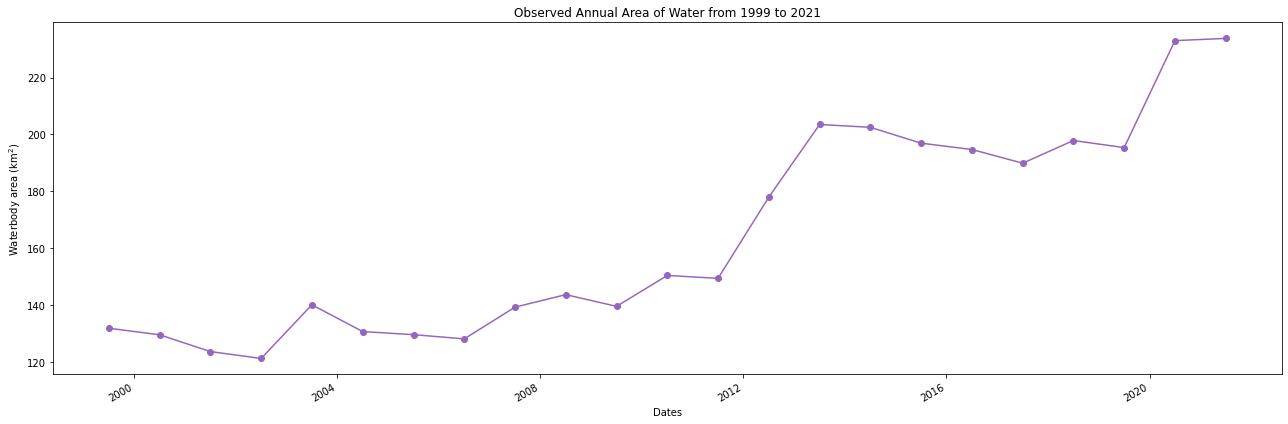

In [13]:
plt.figure(figsize=(18, 6))
ds_valid_water_area.plot(marker='o', color='#9467bd')
plt.title(f'Observed Annual Area of Water from {start_year} to {end_year}')
plt.xlabel('Dates')
plt.ylabel('Waterbody area (km$^2$)')
plt.tight_layout()

## Load and plot rainfall from CHIRPS Africa monthly dataset

In [14]:
rf_ds = dc.load(product='rainfall_chirps_monthly',  **query).rainfall
print(rf_ds)

<xarray.DataArray 'rainfall' (time: 271, y: 1489, x: 1127)>
dask.array<dc_load_rainfall, shape=(271, 1489, 1127), dtype=float32, chunksize=(1, 1000, 1000), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 1999-01-16T11:59:59.500000 ... 2021-07...
  * y            (y) float64 1.008e+05 1.008e+05 ... 5.620e+04 5.618e+04
  * x            (x) float64 3.464e+06 3.464e+06 ... 3.498e+06 3.498e+06
    spatial_ref  int32 6933
Attributes:
    units:         mm
    nodata:        -9999
    crs:           EPSG:6933
    grid_mapping:  spatial_ref


### Convert to annual means across the entire lake region

Ignore 2021 because there is only 7 months of rainfall data so far

In [15]:
rf_ds_annual_sum = rf_ds.sel(time = slice('1999', '2020')).mean(['y','x']).groupby('time.year').sum().compute()

### Calculate long term annual mean rainfall

In [16]:
long_term_annual_mean = rf_ds_annual_sum.mean()

### Fit a linear trend line to rainfall totals

In [17]:
lr = Ridge()
lr.fit(rf_ds_annual_sum.year.values.reshape(-1, 1), rf_ds_annual_sum.values.reshape(-1, 1))
lr_df = pd.DataFrame((lr.coef_*rf_ds_annual_sum.year.values+lr.intercept_).reshape(-1), rf_ds_annual_sum.year.values)


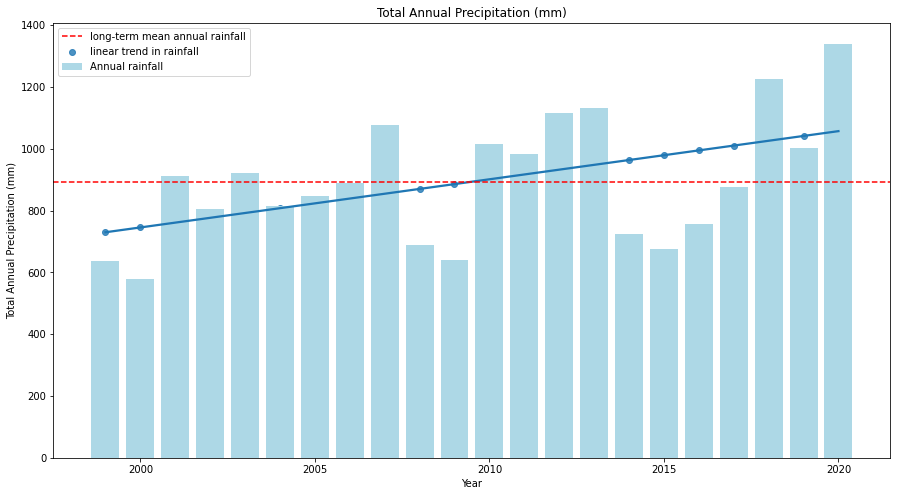

In [18]:
fig, ax = plt.subplots(1,1, figsize=(15, 8))
ax.bar(rf_ds_annual_sum.year.values, rf_ds_annual_sum.values, color="lightblue", label='Annual rainfall')
sns.regplot(x=lr_df.index.values.astype(int), y= lr_df[0], ax=ax, label='linear trend in rainfall')
ax.axhline(y=long_term_annual_mean.values, color='r', linestyle='--', label='long-term mean annual rainfall')
plt.legend()
plt.ylabel('%s (%s)'%('Total Annual Precipitation', rf_ds.attrs['units']));
plt.title('%s (%s)'%('Total Annual Precipitation', rf_ds.attrs['units']))
plt.xlabel('Year');

### Plot rainfall and water extent together

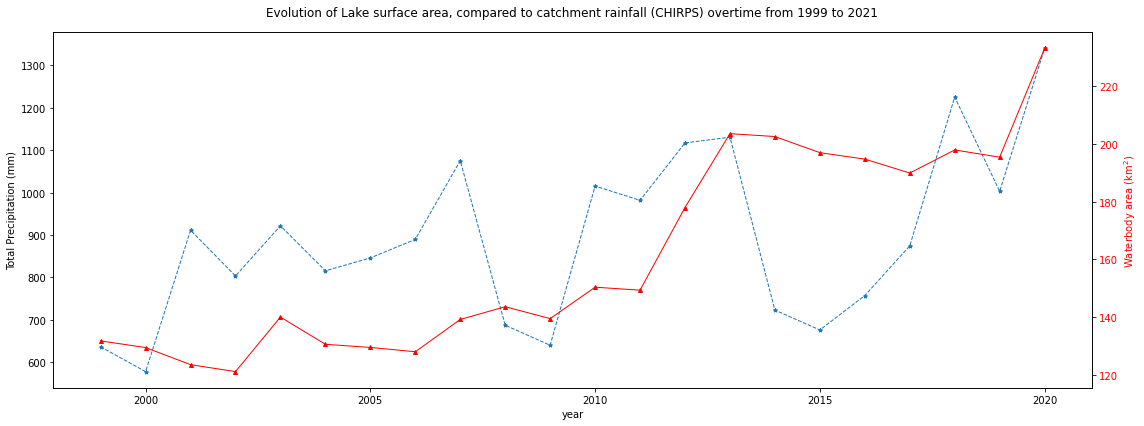

In [19]:
# plot daily total precipitation for this area
fig, ax1 = plt.subplots(figsize=(16,6))

# plt.subplot(2,1,1)
rf_ds_annual_sum.plot(marker='*', markersize=4, linewidth=1, ax=ax1, linestyle='dashed', 
                                    label='Total Precipitation');
# plt.xlabel('');
plt.ylabel('%s (%s)'%('Total Precipitation', rf_ds.attrs['units']));
plt.title('')

ax2 = ax1.twinx()
# plt.subplot(2,1,2)
ax2.plot(rf_ds_annual_sum.year.values, ds_valid_water_area.values[:-1], color='red', marker='^', markersize=4, linewidth=1, label='Waterbody Area')
plt.title('')
# plt.xlabel('Dates')
plt.ylabel('Waterbody area (km$^2$)', color='red')
plt.yticks(color='red')

ax.legend(loc='upper left')
fig.suptitle('Evolution of Lake surface area, compared to catchment rainfall (CHIRPS) over'+ 
             f'time from {start_year} to {end_year}')
fig.tight_layout()

## Determine minimum and maximum water extent
The next cell extract the Minimum and Maximum extent of water from the dataset using the `min` and `max` functions, we then add the dates to an `xarray.DataArray`.

In [20]:
min_water_area_date, max_water_area_date =  min(ds_valid_water_area), max(ds_valid_water_area)
time_xr = xr.DataArray([min_water_area_date.time.values, max_water_area_date.time.values], dims=["time"])

print(time_xr)

<xarray.DataArray (time: 2)>
array(['2002-07-02T11:59:59.999999000', '2021-07-02T11:59:59.999999000'],
      dtype='datetime64[ns]')
Dimensions without coordinates: time


### Plot the dates when the min and max water extent occur
Plot water classified pixel for the two dates where we have the minimum and maximum surface water extent.

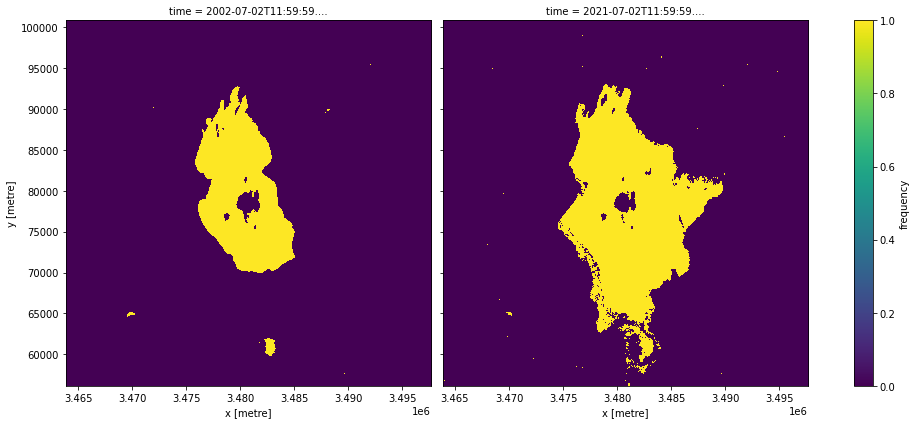

In [21]:
water_extent.sel(time=time_xr).plot.imshow(col="time", col_wrap=2, figsize=(14, 6));

## Compare two time periods
The following cells determine the maximum extent of water for two different years. 
* `baseline_year` : The baseline year for the analysis
* `analysis_year` : The year to compare to the baseline year

In [22]:
baseline_time = '2002'
analysis_time = '2020'

baseline_ds, analysis_ds = ds_valid_water_area.sel(time=baseline_time, method ='nearest'), ds_valid_water_area.sel(time=analysis_time, method ='nearest')

### Plotting

Plot water extent for the two chosen periods.

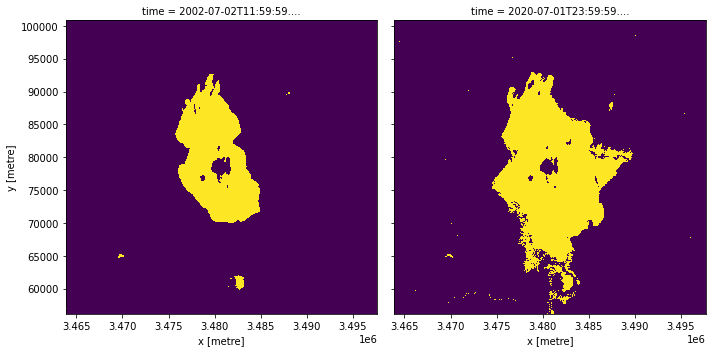

In [23]:
compare = water_extent.sel(time=[baseline_ds.time.values[0], analysis_ds.time.values[0]])

compare.plot(col="time",col_wrap=2,figsize=(10, 5), cmap='viridis', add_colorbar=False);

## Calculating the change for the two nominated periods
The cells below calculate the amount of water gain, loss and stable for the two periods

In [24]:
analyse_total_value = compare.isel(time=1).astype(int)
change = analyse_total_value - compare.isel(time=0).astype(int)

water_appeared = change.where(change == 1)
permanent_water = change.where((change == 0) & (analyse_total_value == 1))
permanent_land = change.where((change == 0) & (analyse_total_value == 0))
water_disappeared = change.where(change == -1)



The cell below calculate the area of water extent for water_loss, water_gain, permanent water and land 

In [25]:
total_area = analyse_total_value.count().values * area_per_pixel
water_apperaed_area = water_appeared.count().values * area_per_pixel
permanent_water_area = permanent_water.count().values * area_per_pixel
water_disappeared_area = water_disappeared.count().values * area_per_pixel

The cell below calculate the area of water extent for water_loss, water_gain, permanent water and land 

In [26]:
total_area = analyse_total_value.count().values * area_per_pixel
water_apperaed_area = water_appeared.count().values * area_per_pixel
permanent_water_area = permanent_water.count().values * area_per_pixel
water_disappeared_area = water_disappeared.count().values * area_per_pixel

## Plotting
The water variables are plotted to visualised the result

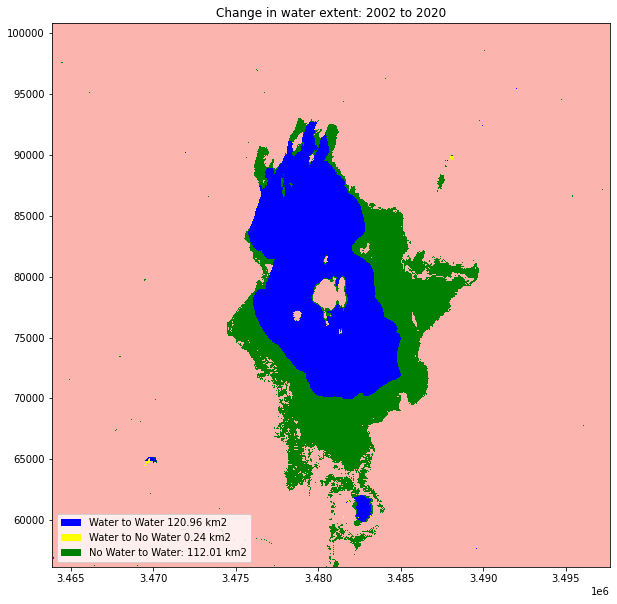

In [27]:
water_appeared_color = "Green"
water_disappeared_color = "Yellow"
stable_color = "Blue"
land_color = "Brown"

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

compare[1].plot.imshow(cmap="Pastel1",
                                       add_colorbar=False,
                                       add_labels=False,
                                       ax=ax)
water_appeared.plot.imshow(
    cmap=ListedColormap([water_appeared_color]),
    add_colorbar=False,
    add_labels=False,
    ax=ax,
)
water_disappeared.plot.imshow(
    cmap=ListedColormap([water_disappeared_color]),
    add_colorbar=False,
    add_labels=False,
    ax=ax,
)
permanent_water.plot.imshow(cmap=ListedColormap([stable_color]),
                            add_colorbar=False,
                            add_labels=False,
                            ax=ax)

plt.legend(
    [
        Patch(facecolor=stable_color),
        Patch(facecolor=water_disappeared_color),
        Patch(facecolor=water_appeared_color),
        Patch(facecolor=land_color),
    ],
    [
        f"Water to Water {round(permanent_water_area, 2)} km2",
        f"Water to No Water {round(water_disappeared_area, 2)} km2",
        f"No Water to Water: {round(water_apperaed_area, 2)} km2",
    ],
    loc="lower left",
)

plt.title("Change in water extent: " + baseline_time + " to " + analysis_time);

## Next steps


Return to the "Analysis parameters" section, modify some values (e.g. `latitude`, `longitude`, `start_year`, `end_year`) and re-run the analysis.
You can use the interactive map in the "View the selected location" section to find new central latitude and longitude values by panning and zooming, and then clicking on the area you wish to extract location values for.
You can also use Google maps to search for a location you know, then return the latitude and longitude values by clicking the map.

Change the year also in "Compare Two Time Periods - a Baseline and an Analysis" section, (e.g. `base_year`, `analyse_year`) and re-run the analysis.

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:**

In [ ]:
print(datacube.__version__)

**Last Tested:**

In [ ]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')